This will focus on augmenting network using visual attention mechanism called "spatial transformer network"

STN allows a neural network to learn how to perform spatial transformation on the input image in order to enhance geometric invariance of the model.

For instance, it can crop a region of interest, scale, and correct orientation of an image.

This is useful mechanism because CNNs are not invariant to "rotation" and "scale" and more general affine transformation

In [7]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

plt.ion() 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# training dataset

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size = 64, shuffle = True, num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, download=True, 
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))                      
                  ])),
    batch_size = 64, shuffle = True, num_workers = 4
)

STN has 3 major components

1. The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformation that enhances the global accuracy

2. The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image

3. The sampler uses the parameters of the transformation and applies it to the input image

In [9]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # spatial transformer localization-network
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for 3 x 2 affine matrix
        
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # initialize weights and bias with identity transformation
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0],
                                                   dtype=torch.float))
        
    # spatial transformer network forward function
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1,2,3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        return x
    
    def forward(self, x):
        x = self.stn(x)
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
model = Net().to(device)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx % 500 == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [17]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.407872
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.352953


C:\Users\Wei Han Chen\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1126, Accuracy: 9667/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.458096
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.243609

Test set: Average loss: 0.0750, Accuracy: 9764/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.238102
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.326341

Test set: Average loss: 0.0772, Accuracy: 9768/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.214452
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.229078

Test set: Average loss: 0.0806, Accuracy: 9764/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.216056
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.081707

Test set: Average loss: 0.0600, Accuracy: 9805/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.109193
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.112963

Test set: Average loss: 0.0591, Accuracy: 9820/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.196032
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.195412

Test set: Average loss: 0.0519, Accuracy: 9832/10000 (98%)

Tra

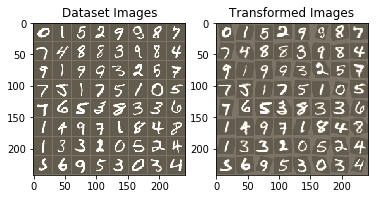

In [18]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()